In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from graphviz import Digraph

import torch

In [2]:
# create our own single-element tensor-like data structure
class Value:
    
    def __init__(self, data, _parent=(), _operation='', label=''):
        self.data = data
        self.grad = 0.0  # keep track the gradient of this value, i.e. how it affects the final mathmatical expression output, i.e. calculated by backprop
        self._backward = lambda: None  # a function that propagates gradient back to calculate gradient
        self._prev = _parent  # keep track of which two Values created this value
        self._op = _operation  # keep track of what operation created this value
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    # define + operator
    def __add__(self, other):
        # check if other is a Value object, if not, cast it to Value
        other = other if isinstance(other, Value) else Value(other)

        out = Value(self.data + other.data, (self, other), '+')

        # + operator just propagates grad back
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    # define other + self (for expressions like int + Value, which gets converted to Value + int by this function)
    def __radd__(self, other):
        return self + other

    # define -self
    def __neg__(self):
        return self * -1

    # define subtraction as self + (-other)
    def __sub__(self, other):
        return self + (-other)

    # define * operator
    def __mul__(self, other):
         # check if other is a Value object, if not, cast it to Value
        other = other if isinstance(other, Value) else Value(other)
        
        out = Value(self.data * other.data, (self, other), '*')

        # local derivative of a * operator is just the other input, then multiply local derivative with the grad of output (backprop gradient)
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    # define other * self (for expressions like int * Value, which gets converted to Value * int by this function)
    def __rmul__(self, other):
        return self * other

    # define division, a / b is just a * 1/b -> a * b**-1
    def __truediv__(self, other):
        return self * other**-1

    # define power function
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float powers for now"
        out = Value(self.data**other, (self, ), f'**{other}')

        # derivative of x^y is yx^(y-1), then multiply the grad of output
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    # define e^x
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        # derivative of e^x is just e^x, then multiply the grad of output
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    # define tanh activation
    def tanh(self):
        x = self.data
        out = Value((math.exp(2 * x) - 1) / (math.exp(2 * x) + 1), (self, ), 'tanh')

        # derivative of tanh is 1 - tanh(x)^2, from wiki, then multiply the grad of output (backprop gradient)
        def _backward():
            self.grad += (1 - (out.data)**2) * out.grad
        out._backward = _backward

        return out

    # call this function on the output node, to backprop all gradients
    def backward(self):
        self.grad = 1.0  # set output grad to 1, since class init to 0

        # use a topological sort on the expression to call backprop automatically, starting with the output
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for parent in node._prev:
                    build_topo(parent)
                topo.append(node)

        # this will flatten out the output's mathmatical expression
        build_topo(self)

        # visit each node and backprop, reverse order to start from the output
        for node in reversed(topo):
            node._backward()
        

# Forward pass

In [3]:
# define a mathmatical expression, L = (a * b + c) * f
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
d = a * b                       # d = -6
d.label = 'd'
e = d + c                       # e = 4
e.label = 'e'
f = Value(-2.0, label='f')
L = e * f
L.label = 'L'
L

Value(data=-8.0)

In [4]:
# helper functions to visualize the mathmatical expression

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

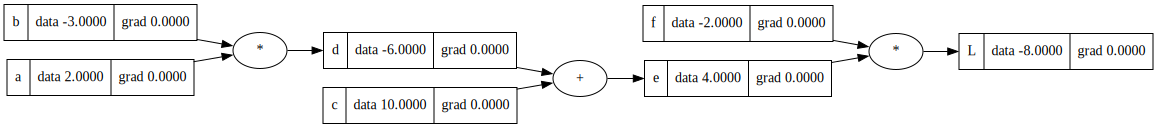

In [5]:
draw_dot(L)

# Backpropagation

In [6]:
# L = (a * b + c) * f

# dL/dL is just 1 (derivative on itself)
L.grad = 1.0

# dL/df = e, since L = e * f
f.grad = e.data

# dL/de = f , since L = e * f
e.grad = f.data

# dL/dc = f
# since dL/dc = dL/de * de/dc (e = d + c, de/dc is just 1)
# -> dL/dc = f * 1 = f
c.grad = f.data

# dL/dd = f as well, i.e. a (+) op just back flows the gradient to the operands
d.grad = f.data

# dL/da = dL/dd * dd/da = f * b
a.grad = f.data * b.data

# dL/db = dL/dd * dd/db = f * a
b.grad = f.data * a.data


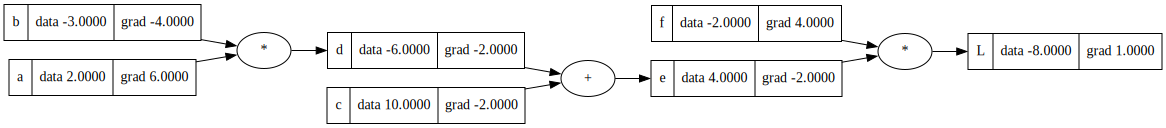

In [7]:
draw_dot(L)

# Neurons

In [8]:
# a neuron with 2 inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# each input has a weight
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# each neuron has a bias (arbitrary value just for manual backpropagation numbers look more comprehensive)
b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1
x1w1.label = 'x1 * w1'
x2w2 = x2 * w2
x2w2.label = 'x2 * w2'

x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1 * w1 + x2 * w2'

# neuron = sum of (each input * weight) + bias
neuron = x1w1x2w2 + b
neuron.label = 'neuron'

# neuron activation
output = neuron.tanh()
output.label = 'output'

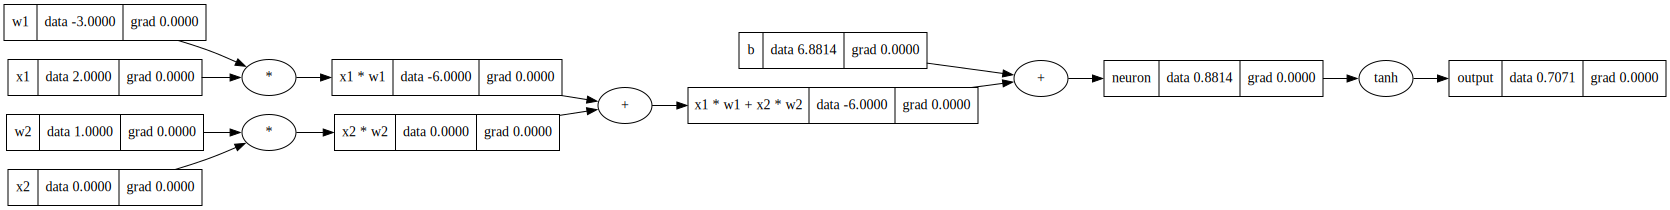

In [9]:
draw_dot(output)

In [10]:
# backpropagation, output = tanh(x1w1 + x2w2 + b)

# gradient of output is just 1
output.grad = 1.0

# do/dn = 1 - tanh(n)^2 (derivative of tanh, from wiki)
# -> do/dn = 1 - output^2
neuron.grad = 1 - (output.data)**2

# + operator just backflows the gradient
x1w1x2w2.grad = neuron.grad
b.grad = neuron.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# do/dx2 = do/dx2w2 * dx2w2/dx2 (local derivative of a * operator is just the other input)
x2.grad = x2w2.grad * w2.data

# do/dw2 = do/dx2w2 * dx2w2/dw2
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data

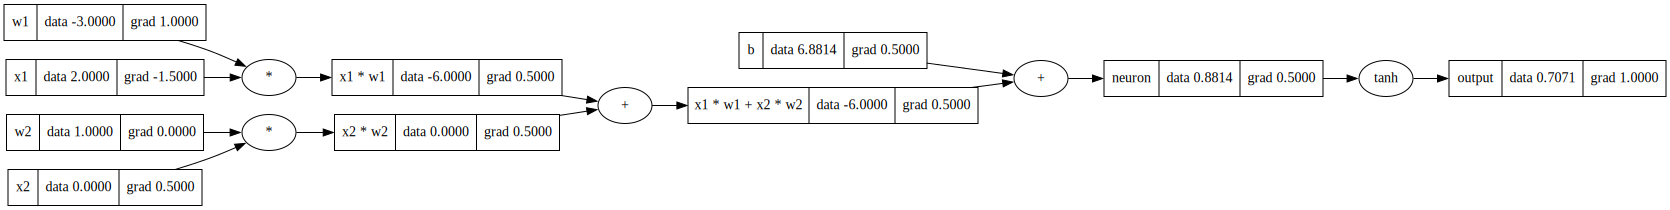

In [11]:
draw_dot(output)

In [12]:
# that was manual calculation, now use the implemented backprop function to backprop gradient

# clear the manual calulcated gradients first
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1
x1w1.label = 'x1 * w1'
x2w2 = x2 * w2
x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1 * w1 + x2 * w2'
neuron = x1w1x2w2 + b
neuron.label = 'neuron'
output = neuron.tanh()
output.label = 'output'

# backprop
output.grad = 1.0  # set output gradient to 1 first (since the class init to 0)
output._backward()
neuron._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

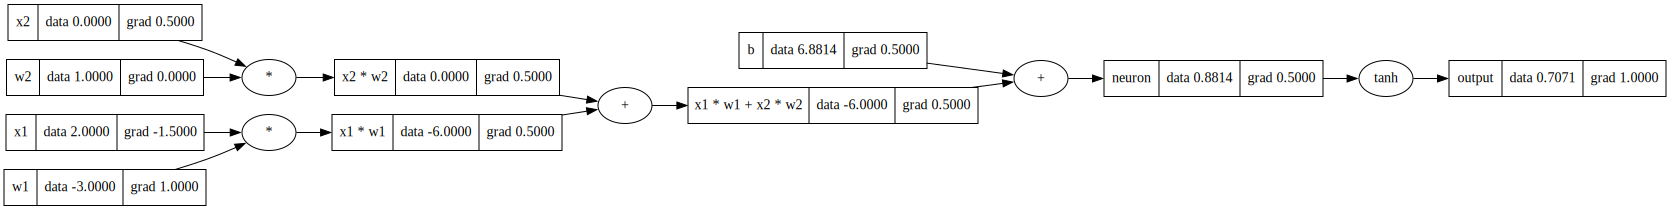

In [13]:
draw_dot(output)

In [14]:
# use a topological sort on the expression to call backprop automatically, starting with the output

# clear the manual calulcated gradients first
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1
x1w1.label = 'x1 * w1'
x2w2 = x2 * w2
x2w2.label = 'x2 * w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1 * w1 + x2 * w2'
neuron = x1w1x2w2 + b
neuron.label = 'neuron'
output = neuron.tanh()
output.label = 'output'

output.backward()

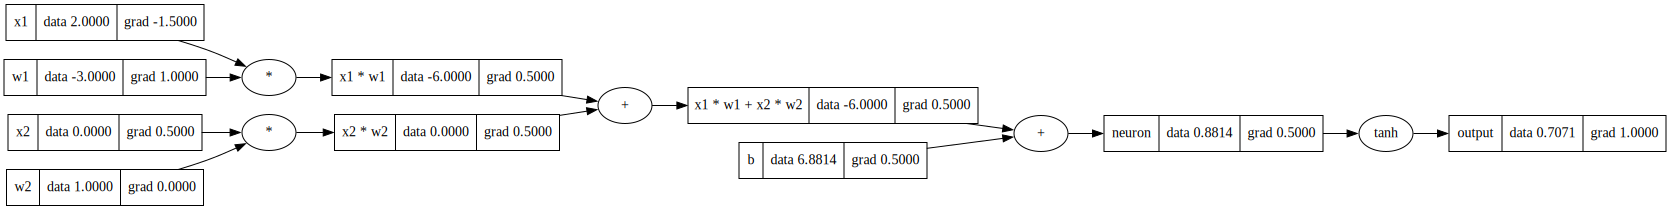

In [15]:
draw_dot(output)

# Compare with Pytorch

In [16]:
# same neuron implemented in pytorch, i.e. output = tanh(x1w1 + x2w2 + bias)
x1 = torch.Tensor([2.0]).double()  # cast to float64 precision
x2 = torch.Tensor([0.0]).double()
w1 = torch.Tensor([-3.0]).double()
w2 = torch.Tensor([1.0]).double()
b = torch.Tensor([6.8813735870195432]).double()

# tell pytorch to compute gradients on these tensors
x1.requires_grad = True
x2.requires_grad = True
w1.requires_grad = True
w2.requires_grad = True
b.requires_grad = True

# neuron and output
neuron = x1 * w1 + x2 * w2 + b
output = torch.tanh(neuron)

# backprop to calculate gradients
output.backward()

# print out pytorch calculated values (to compare with our implementation)
print(output.data.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x2', x2.grad.item())
print('w2', w2.grad.item())



0.7071066904050358
x1 -1.5000003851533106
w1 1.0000002567688737
x2 0.5000001283844369
w2 0.0


# Neural network

In [17]:
# define the class for a neuron
class Neuron:

    def __init__(self, num_input):
        # each input has a weight, init to random
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_input)]
        self.b = Value(random.uniform(-1, 1))

    # define forward pass, i.e. w * x + b
    def __call__(self, x):
        raw_activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        output = raw_activation.tanh()  # use tanh activation on the raw neuron output
        return output

    # return a list of all the parameters of this neuron, i.e. all ws and b
    def parameters(self):
        return self.w + [self.b]

In [18]:
# define the class for a layer of neurons
class Layer:

    def __init__(self, num_input, num_output):
        # create the number of neurons in this layer, which = num_output of this layer
        self.neurons = [Neuron(num_input) for _ in range(num_output)]

    # forward pass on every neuron in this layer
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    # return a list of all the parameters of this layer, i.e. all ws and b of all neurons
    def parameters(self):
        return [param for neuron in self.neurons for param in neuron.parameters()]

In [19]:
# define the class for MLP
class MLP:

    def __init__(self, num_input, num_outputs):
        # add num_input to front of list, i.e. if num_input = 2, num_outputs = (3, 4), then sizes = (2, 3, 4)
        sizes = [num_input] + num_outputs

        # create each layer, by iterating the num_input, num_output in the list
        self.layers = [Layer(sizes[i], sizes[i+1]) for i in range(len(num_outputs))]

    # forward pass through the layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    # return a list of all the parameters of this MLP, i.e. all ws and b of all layers and neurons
    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [20]:
# create a MLP with 3 inputs, 2 hidden layers of 4 neurons each, and 1 output
num_input = 3
num_outputs = [4, 4, 1]
model = MLP(num_input, num_outputs)

# arbitrary input
x = [2.0, 3.0, -1.0]
model(x)

Value(data=0.3401939004043905)

In [21]:
# create arbitrary dataset with 4 samples
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # targets

# before traininig
y_pred = [model(x) for x in xs]
y_pred

[Value(data=0.3401939004043905),
 Value(data=-0.15674459629975634),
 Value(data=0.46685246474029884),
 Value(data=-0.5313811588795626)]

In [22]:
# training loop
epochs = 20
learning_rate = 0.05

for epoch in range(epochs):
    # forward pass
    y_preds  = [model(x) for x in xs]

    # calculate MSE loss
    loss = sum((y_pred - y_true)**2 for y_true, y_pred in zip(ys, y_preds))

    # zero out grads before backward pass, so grads don't accumulate between epochs
    for p in model.parameters():
        p.grad = 0.0

    # backward pass to calculate gradients for all parameters
    loss.backward()

    # gradient descent on all parameters
    for p in model.parameters():
        p.data += -learning_rate * p.grad

    print(epoch, loss.data)

0 5.643208172019234
1 4.164950934198049
2 3.267215685523886
3 2.6650924957989544
4 2.2701530106558216
5 1.9602158467086672
6 1.6584182460230168
7 1.337174716173617
8 1.007192607506447
9 0.7126496724042766
10 0.494463213871448
11 0.35279130727264896
12 0.26373648825221513
13 0.2061094436279462
14 0.16703067370462227
15 0.13929312783893336
16 0.11881506041748141
17 0.10319183662870601
18 0.09094313806437493
19 0.08111916738055264


In [23]:
y_preds

[Value(data=0.9767305865355994),
 Value(data=-0.8026082283616452),
 Value(data=-0.8609513359259723),
 Value(data=0.8507362760538408)]